# ATE estimations from generated RCT data
*This notebook examines the use of Bayesian Networks for estimating Average Treatment Effects (ATE) in Randomized Controlled Trials (RCTs) within the Neyman-Rubin potential outcome framework from generated data.*

### Context

The potential outcomes framework consists of having a set of $n$ independent and identically distributed units. An observation on the $i$-th unit is given by the tuple $(T_i, X_i, Y_i)$ where:
* $ T_i \in \{0,1\} $ is the treatment assignment.
* $ X_i \in \mathbb{R}^d $ is the covariate vector.
* $ Y_i \in \mathbb{R} $ is the observed outcome of the treatment.

Under the framekwork's assumption, the *observed* outcome can be expressed as:
$$ Y_i = Y_i(T_i) = T_iY_i(1) + (1-T_i)Y_i(0)$$
with $Y_i(1)$ and $Y_i(0)$ representing the treated and untreated *potential* outcomes, respectively.

We aim to quantify the effect of a given treatment on the population, namely the quantity $ \Delta_i = Y_i(1) - Y_i(0) $. Althought this value cannot be directed calculated due to the presence of counterfactuals (since we cannot observe both the treated and untreated outcomes for a given unit), there exists methods for approximating its expected value, the Avereage Treatment Effect $\tau$: $$ \tau = \mathbb{E}\left[\frac{1}{n}\sum_{i=1}^n \Delta_i\right] = \mathbb{E}[Y(1)] - \mathbb{E}[Y(0)]$$

In this notebook, we consider the setting of a Randomized Controlled Trial (RCT), where the ignorability assumption holds:
* $T_i \perp\!\!\!\perp \{Y_i(0), Y_i(1)\}$

Here, the *observed outcome* $Y_i$ is dependent of $T_i$, and independent of other treatments, but the *potential outcomes* $Y_i(0)$ and $Y_i(1)$ are independent of $T_i$.

We will present estimators of $\tau$ using Baysian Networks on generated data through three different methods:
* "Exact" Computation
* Parameter Learning
* Structure Learning

In [8]:
import pyAgrum as gum
import pyAgrum.skbn as skbn
import pyAgrum.lib.notebook as gnb

from scipy.stats import norm
from scipy.integrate import quad

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 6})

### Generated Data

Consider two generative models:

* A linear generative model described by the equation:
$$ Y = 3X_1 + 2X_2 -2X_3 -0.8X_4 + T(2X_1 + 5X_3 +3X_4) $$

* And a non-linear generative model described by the equation:
$$ Y = 3X_1 + 2X_2^2 -2X_3 -0.8X_4 +10T $$


Where $ (X_1,X_2,X_3,X_4) \sim \mathcal{N}_4((1,1,1,1), I_4) $, $T \sim \mathcal{Ber}(1/2)$ and $ (X_1,X_2,X_3,X_4,T) $ are jointly independent in both of the models.

Data from the models can be obtatined by the functions given below.

In [9]:
def linear_simulation(n : int, sigma : float) -> pd.DataFrame:
  """
  Returns n observations from the linear model with normally distributed
  noise with expected value 0 and standard deviation sigma.
  """

  X1 = np.random.normal(1, 1, n)
  X2 = np.random.normal(1, 1, n)
  X3 = np.random.normal(1, 1, n)
  X4 = np.random.normal(1, 1, n)
  epsilon = np.random.normal(0, sigma, n)
  T=np.random.binomial(1, 0.5, n)
  Y= 3*X1+2*X2-2*X3-0.8*X4+T*(2*X1+5*X3+3*X4)+epsilon
  d=np.array([T,X1,X2,X3,X4,Y])
  df_data = pd.DataFrame(data=d.T,columns=['T','X1','X2','X3','X4','Y'])
  df_data["T"] = df_data["T"].astype(int)

  return df_data

def non_linear_simulation(n : int, sigma : float) -> pd.DataFrame:
  """
  Returns n observations from the non-linear model with normally distributed
  noise with expected value 0 and standard deviation sigma.
  """

  X1 = np.random.normal(1, 1, n)
  X2 = np.random.normal(1, 1, n)
  X3 = np.random.normal(1, 1, n)
  X4 = np.random.normal(1, 1, n)
  epsilon = np.random.normal(0, sigma, n)
  T=np.random.binomial(1, 0.5, n)
  Y= 3*X1+ 2*X2**2-2*X3-0.8*X4+10*T+epsilon
  d=np.array([T,X1,X2,X3,X4,Y])
  df_data = pd.DataFrame(data=d.T,columns=['T','X1','X2','X3','X4','Y'])
  df_data["T"] = df_data["T"].astype(int)

  return df_data

Furthermore, the expected values of $Y(0)$ and $Y(1)$ can be explicitly calculated, providing us the theoretical ATE which will serve as a point of reference for the estimations.

Both models have an ATE of $ \tau = 10 $, their probability density functions are plotted below. 

In [10]:
X = np.linspace(-20, 40, 120)
dx = X[1] - X[0]

# Linear model

lin_y0_mean, lin_y0_var = (2.2, 17.64)
lin_y1_mean, lin_y1_var = (12.2, 42.84)
lin_y0 = norm(loc=lin_y0_mean, scale=np.sqrt(lin_y0_var)).pdf(X)
lin_y1 = norm(loc=lin_y1_mean, scale=np.sqrt(lin_y1_var)).pdf(X)
lin_pdf_df = pd.DataFrame(data={"y0": lin_y0, "y1": lin_y1}, index=X)

# Non Linear model

def twoX2squared_func(x):
    if x <= 0:
        return 0
    else:
        return (norm(1, 1).pdf(np.sqrt(x/2.0)) +
                norm(1, 1).pdf(-np.sqrt(x/2.0))) / (4.0*np.sqrt(x))

def convolve(f, g):
    return (lambda t: quad((lambda x: f(t-x)*g(x)), -np.inf, np.inf))

nl_y0_norm_mean, nl_y0_norm_var = (0.2, 13.64)
nl_y1_norm_mean, nl_y1_norm_var = (10.2, 13.64)
nl_y0_norm = norm(loc=nl_y0_norm_mean, scale=np.sqrt(nl_y0_norm_var)).pdf
nl_y1_norm = norm(loc=nl_y1_norm_mean, scale=np.sqrt(nl_y1_norm_var)).pdf
nl_y0_func = convolve(nl_y0_norm, twoX2squared_func)
nl_y1_func = convolve(nl_y1_norm, twoX2squared_func)
nl_y0 = list()
nl_y1 = list()

for x in X:
    nl_y0.append(nl_y0_func(x)[0])
    nl_y1.append(nl_y1_func(x)[0])

nl_y0, nl_y1 = (np.array(nl_y0), np.array(nl_y1))
nl_y0, nl_y1 = (nl_y0/(nl_y0.sum()*dx), nl_y1/(nl_y1.sum()*dx))

nl_pdf_df = pd.DataFrame(data={"y0": nl_y0, "y1": nl_y1}, index=X)

# Runtime ~ 1m30

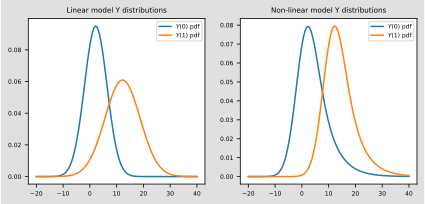

In [11]:
# Plotting the distributions

plt.subplots(figsize=(7, 3))

plt.subplot(1, 2, 1)

plt.plot(X, lin_y0, color="tab:blue", label="$Y(0)$ pdf")
plt.plot(X, lin_y1, color="tab:orange", label="$Y(1)$ pdf")
plt.legend()
plt.title("Linear model Y distributions")

plt.subplot(1, 2, 2)

plt.plot(X, nl_y0, color="tab:blue", label="$Y(0)$ pdf")
plt.plot(X, nl_y1, color="tab:orange", label="$Y(1)$ pdf")
plt.legend()
plt.title("Non-linear model Y distributions")

plt.show()

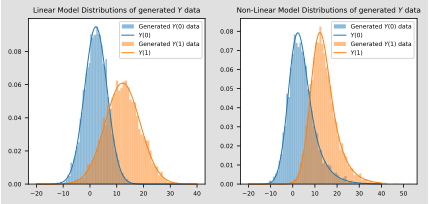

In [13]:
# Visualisation of generated data used for Learning

lin_df = linear_simulation(10000, 1.0)
nl_df = non_linear_simulation(10000, 1.0)

plt.subplots(figsize=(7, 3))

plt.subplot(1, 2, 1)

plt.hist(lin_df[lin_df["T"] == 0]["Y"], bins=60, density=True,
         alpha=0.5, color="tab:blue", label="Generated $Y(0)$ data")
plt.plot(lin_pdf_df["y0"], color="tab:blue", label="$Y(0)$", linewidth=1)
plt.hist(lin_df[lin_df["T"] == 1]["Y"], bins=60, density=True,
         alpha=0.5, color="tab:orange", label="Generated $Y(1)$ data")
plt.plot(lin_pdf_df["y1"], color="tab:orange", label="$Y(1)$", linewidth=1)
plt.title("Linear Model Distributions of generated $Y$ data")
plt.legend()

plt.subplot(1, 2, 2)

plt.hist(nl_df[nl_df["T"] == 0]["Y"], bins=60, density=True,
         alpha=0.5, color="tab:blue", label="Generated $Y(0)$ data")
plt.plot(nl_pdf_df["y0"], color="tab:blue", label="$Y(0)$", linewidth=1)
plt.hist(nl_df[nl_df["T"] == 1]["Y"], bins=60, density=True,
         alpha=0.5, color="tab:orange", label="Generated $Y(1)$ data")
plt.plot(nl_pdf_df["y1"], color="tab:orange", label="$Y(1)$", linewidth=1)
plt.title("Non-Linear Model Distributions of generated $Y$ data")
plt.legend()

plt.show()

In [14]:
# Y Expressions

lin_expr = "3*X1 + 2*X2 - 2*X3 - 0.8*X4 + T*(2*X1 + 5*X3 + 3*X4)"
nl_expr = "3*X1 + 2*(X2*X2) - 2*X3 - 0.8*X4 + 10*T"

### 1 - "Exact" Computation

Exact theoretical expected values can be calculated using Bayesian Networks by inputting the data-generating distribution directly into the network. However, since pyAgrum does not support continuous variables as of July 2024, a discretization of continuous distributions is necessary. Consequently, the calculated value will not be exact in a strict sense, but with a sufficient number of discrete states, a close enough approximation can be achieved.

In [15]:
# Definitions of functions used in this section

def getStringIntervalMean(interval_string : str) -> float:
    """
    Returns the mean of a interval casted as string (e.g. [1.5, 2.9[).
    """

    separator = 0
    start = ""
    end = ""
    for c in interval_string:
        if str.isdecimal(c) or c in {"-", "."}:
            if separator == 1:
                start += c
            else:
                end += c
        else:
            separator += 1
    start = float(start)
    end = float(end)

    return (start + end)/2.0

def getY(bn : gum.BayesNet) -> tuple[pd.DataFrame]:
    """
    Returns the estimation of outcomes Y(0), Y(1) with Lazy Propagation
    from the inputed Baysian Network as a pandas Data Frame couple.
    """

    ie = gum.LazyPropagation(bn)

    ie.setEvidence({"T": 0})
    ie.makeInference()
    var_labels = list()
    var = ie.posterior("Y").variable(0)
    for i in range(var.domainSize()):
        var_labels.append(var.label(i))
    Y0 = pd.DataFrame({"T": 0, "interval": var_labels,
                       "probability": ie.posterior("Y").tolist()})
    Y0["interval_mean"] = Y0["interval"].apply(getStringIntervalMean)

    ie.setEvidence({"T": 1})
    ie.makeInference()
    var_labels = list()
    var = ie.posterior("Y").variable(0)
    for i in range(var.domainSize()):
        var_labels.append(var.label(i))
    Y1 = pd.DataFrame({"T": 1, "interval": var_labels,
                       "probability": ie.posterior("Y").tolist()})
    Y1["interval_mean"] = Y1["interval"].apply(getStringIntervalMean)

    return (Y0, Y1)

def getTau(Y : tuple[pd.DataFrame]) -> float:
    """
    Returns estimation of the ATE tau from pandas Data Frame couple
    (Y(0), Y(1)).
    """

    E0 = (Y[0]["interval_mean"] * Y[0]["probability"]).sum()
    E1 = (Y[1]["interval_mean"] * Y[1]["probability"]).sum()
    tau = E1 - E0

    return tau

def plotResults(Y_hat : pd.DataFrame, Y : pd.DataFrame,
                plot_title : str) -> None:
    """
    Scatters Y_hat data and plots Y data in a plot titled plot_title.
    """

    plt.scatter(x=Y_hat[0]["interval_mean"] ,y=Y_hat[0]["probability"],
                color="tab:blue", label=r"$\hat{Y}(0)$", s=10)
    plt.scatter(x=Y_hat[1]["interval_mean"] ,y=Y_hat[1]["probability"],
                color="tab:orange", label=r"$\hat{Y}(1)$", s=10)
    plt.plot(Y["y0"], color="tab:blue", label="Y(0)")
    plt.plot(Y["y1"], color="tab:orange", label="Y(1)")
    plt.title(plot_title)
    plt.legend()

In [16]:
def getBN(# Covariate parameters
          covariate_start : int = -3.0,
          covariate_end : int = 5.0 ,
          covariate_num_split : int = 10,
          covariate_distribution = None,
          # Outcome parameters
          outcome_start = -20.0 ,
          outcome_end = 40.0 ,
          outcome_num_split = 60,
          outcome_loc_expr : str | None = None,
          # Other
          data : pd.DataFrame | None = None,
          add_arcs : bool = True) -> gum.BayesNet:
    """
    Returns Baysian Network corresponding to the model by discretising
    countinous variables with given parameters.
    """
    if data is None:
        bn = gum.BayesNet()
        for i in range(1,5):
            bn.add(f"X{i}[{covariate_start}:{covariate_end}:{covariate_num_split}]")
        bn.add("T[2]")
        bn.add(f"Y[{outcome_start}:{outcome_end}:{outcome_num_split}]")

    else :
        disc = skbn.BNDiscretizer(defaultDiscretizationMethod="uniform",
                                  defaultNumberOfBins=covariate_num_split)
        disc.setDiscretizationParameters("T", 'NoDiscretization', [0, 1])
        disc.setDiscretizationParameters("Y", 'uniform', outcome_num_split)
        bn = disc.discretizedBN(data)

    if add_arcs :
        bn.beginTopologyTransformation()
        for _, name in bn:
            if name != "Y":
                bn.addArc(name, "Y")
        bn.endTopologyTransformation()

    if covariate_distribution is not None :
        bn.cpt("T").fillWith([0.5, 0.5])
        for i in range(1,5):
            bn.cpt(f"X{i}").fillFromDistribution(covariate_distribution)

    if outcome_loc_expr is not None:
        bn.cpt("Y").fillFromDistribution(norm, loc=outcome_loc_expr, scale=1)

    return bn

Employing a 10-bin discretization for the covariates and a 60-bin discretization for the outcome, the Bayesian Network estimator accurately approximates the true distribution for both the treated and untreated outcome.

In [17]:
lin_exbn = getBN(covariate_distribution=norm(loc=1, scale=1),
                 outcome_loc_expr=lin_expr)
nl_exbn  = getBN(covariate_distribution=norm(loc=1, scale=1),
                 outcome_loc_expr=nl_expr)
print(lin_exbn)

gnb.sideBySide(gnb.getInference(lin_exbn, evs={"T":0}, size="10"),
               gnb.getInference(lin_exbn, evs={"T":1}, size="10"),
               captions=["Linear Y(0)", "Linear Y(1)"]) 

gnb.sideBySide(gnb.getInference(nl_exbn, evs={"T":0}, size="10"),
               gnb.getInference(nl_exbn, evs={"T":1}, size="10"),
               captions=["Non-Linear Y(0)", "Non-Linear Y(1)"])

BN{nodes: 6, arcs: 5, domainSize: 10^6.07918, dim: 1180037, mem: 9Mo 159Ko 336o}


From now on, obtaining the average treatment effect is straightforward using pyAgrum's LazyPropagation exact inference. This involves setting the evidence of the treatment $T$ to $0$ and then to $1$ to compute the respective posterior CPTs. The ATE is subsequently obtained by performing manipulations on the difference between the CPTs.

In [18]:
def ATE(bn : gum.BayesNet) -> float:
    """
    Returns estimation of the ATE directly from Baysian Network.
    """
    ie = gum.LazyPropagation(bn)

    ie.setEvidence({"T": 0})
    ie.makeInference()
    p0 = ie.posterior("Y")

    ie.chgEvidence("T",1)
    ie.makeInference()
    p1 = ie.posterior("Y")

    dif = p1 - p0
    return dif.expectedValue(lambda d: dif.variable(0).numerical(d[dif.variable(0).name()]))

In [19]:
print(lin_exbn)
print(f"{ATE(lin_exbn) = }")
print(f"\n{nl_exbn}")    
print(f"{ATE(nl_exbn) = }")

BN{nodes: 6, arcs: 5, domainSize: 10^6.07918, dim: 1180037, mem: 9Mo 159Ko 336o}
ATE(lin_exbn) = 9.999976078558515

BN{nodes: 6, arcs: 5, domainSize: 10^6.07918, dim: 1180037, mem: 9Mo 159Ko 336o}
ATE(nl_exbn) = 9.986645013271817


Let's examine how the fineness of covariate discretization impacts the outcome distribution.

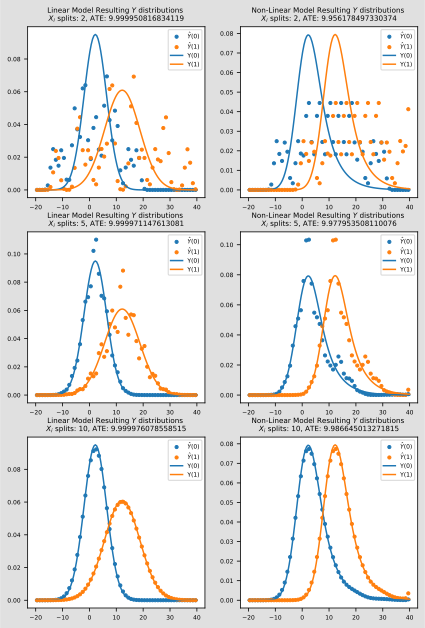

In [20]:
num_split_list = [2, 5, 10]

plt.subplots(figsize=(7, 3.5*len(num_split_list)))

for i in range(len(num_split_list)):

    covariate_num_split = num_split_list[i]

    # Linear Model

    plt.subplot(len(num_split_list), 2, 2*i+1)
    lin_ex_bn = getBN(covariate_num_split=num_split_list[i],
                      covariate_distribution=norm(loc=1, scale=1),
                      outcome_loc_expr=lin_expr)
    lin_Y_hat = getY(lin_ex_bn)
    plotResults(lin_Y_hat, lin_pdf_df,
                f"Linear Model Resulting $Y$ distributions \n" \
                f"$X_i$ splits: {covariate_num_split}, " \
                f"ATE: {getTau(lin_Y_hat)}")

    # Non Linear Model

    plt.subplot(len(num_split_list), 2, 2*i+2)
    nl_ex_bn = getBN(covariate_num_split=num_split_list[i],
                     covariate_distribution=norm(loc=1, scale=1),
                     outcome_loc_expr=nl_expr)
    nl_Y_hat = getY(nl_ex_bn)
    plotResults(nl_Y_hat, nl_pdf_df,
                f"Non-Linear Model Resulting $Y$ distributions \n" \
                f"$X_i$ splits: {covariate_num_split}, " \
                f"ATE: {getTau(nl_Y_hat)}")

plt.show()

Finer discretization with a greater number of bins results in improved approximations of the probability density functions. However, despite the use of rough discretization, the estimations of the ATE remain remarkably accurate.

### 2 - Parameter Learning

Given the data generating function defined above, parameter learning methods can be employed to infer the underlying distribution based on the given structure of the Bayesian network. The default Mutual Information based Inference of Causal Networks (MIIC) algorithm utilized  in the `BNLearner` class effectively performs this task.

In [21]:
# Linear Model

lin_template = getBN(data=lin_df)

lin_p_learner = gum.BNLearner(lin_df, lin_template)
lin_p_learner.useNMLCorrection()
lin_p_learner.useSmoothingPrior(1e-6)

lin_plbn = gum.BayesNet(lin_template)
lin_p_learner.fitParameters(lin_plbn)

# Non-Linear Model

nl_template = getBN(data=nl_df)

nl_p_learner = gum.BNLearner(nl_df, nl_template)
nl_p_learner.useNMLCorrection()
nl_p_learner.useSmoothingPrior(1e-6)

nl_plbn = gum.BayesNet(nl_template)
nl_p_learner.fitParameters(nl_plbn)

print(lin_p_learner)
gnb.sideBySide(gnb.getInference(lin_plbn, evs={"T":0}, size="10"),
               gnb.getInference(lin_plbn, evs={"T":1}, size="10"),
               captions=["Linear Y(0)", "Linear Y(1)"])

print(nl_p_learner)
gnb.sideBySide(gnb.getInference(nl_plbn, evs={"T":0}, size="10"),
               gnb.getInference(nl_plbn, evs={"T":1}, size="10"),
               captions=["Non-Linear Y(0)", "Non-Linear Y(1)"])

Filename       : /tmp/tmpqidxy2el.csv
Size           : (10000,6)
Variables      : T[2], X1[10], X2[10], X3[10], X4[10], Y[60]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : NML  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 0.000001



Filename       : /tmp/tmp7q86bsuq.csv
Size           : (10000,6)
Variables      : T[2], X1[10], X2[10], X3[10], X4[10], Y[60]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : NML  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 0.000001



We observe that the inferred outcome distribution generally matches the exact distribution. However, the ATE seems to be biased, as it is consistently smaller.

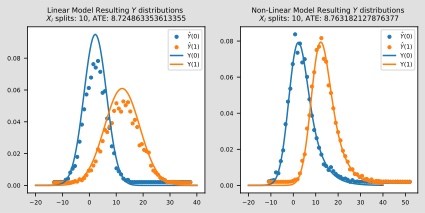

In [22]:
plt.subplots(figsize=(7, 3))

plt.subplot(1, 2, 1)

lin_Y = getY(lin_plbn)
plotResults(lin_Y, lin_pdf_df,
            f"Linear Model Resulting $Y$ distributions \n" \
            f"$X_i$ splits: {covariate_num_split}, ATE: {getTau(lin_Y)}")

plt.subplot(1, 2, 2)

nl_Y = getY(nl_plbn)
plotResults(nl_Y, nl_pdf_df,
            f"Non-Linear Model Resulting $Y$ distributions \n" \
            f"$X_i$ splits: {covariate_num_split}, ATE: {getTau(nl_Y)}")

This underestimation can be further observed with varying numbers of observations in both models.

In [23]:
lin_tau_hat_arr = list()
nl_tau_hat_arr = list()

num_obs_list = [5000, 10000, 20000, 40000]
num_shots = 10

for i in num_obs_list:

    lin_tau_hat_arr.append(list())
    nl_tau_hat_arr.append(list())

    for j in range(num_shots):

        lin_df = linear_simulation(i, 1.0)
        nl_df = non_linear_simulation(i, 1.0)

        discretizer = skbn.BNDiscretizer("uniform", 30)

        # Linear Model

        lin_template = getBN(data=lin_df)

        lin_p_learner = gum.BNLearner(lin_df, lin_template)
        lin_p_learner.useNMLCorrection()
        lin_p_learner.useSmoothingPrior(1e-6)
        lin_p_learner.setSliceOrder([["T"],["X1","X2","X3","X4"],["Y"]])

        lin_plbn = gum.BayesNet(lin_template)
        lin_p_learner.fitParameters(lin_plbn)

        lin_Y_hat = getY(lin_plbn)
        lin_tau_hat = getTau(lin_Y_hat)
        lin_tau_hat_arr[-1].append(lin_tau_hat)

        # Non-Linear Model

        nl_template = getBN(data=nl_df)

        nl_p_learner = gum.BNLearner(nl_df, nl_template)
        nl_p_learner.useNMLCorrection()
        nl_p_learner.useSmoothingPrior(1e-6)
        nl_p_learner.setSliceOrder([["T"],["X1","X2","X3","X4"],["Y"]])

        nl_plbn = gum.BayesNet(nl_template)
        nl_p_learner.fitParameters(nl_plbn)

        nl_Y_hat = getY(nl_plbn)
        nl_tau_hat = getTau(nl_Y_hat)
        nl_tau_hat_arr[-1].append(nl_tau_hat)

TypeError: boxplot() got an unexpected keyword argument 'tick_labels'

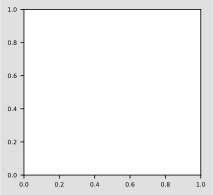

In [24]:
plt.subplots(figsize=(7, 3))

plt.subplot(1, 2, 1)

plt.boxplot(lin_tau_hat_arr, tick_labels=num_obs_list, meanline=False,
            showmeans=True, showcaps=True)
plt.axhline(y=10, color='r', linestyle='--', linewidth=1)
plt.title(f"Linear Model ATE evolution ({num_shots} runs)")
plt.xlabel("Number of observations")
plt.ylabel(r"$\hat{ATE}$")

plt.subplot(1, 2, 2)

plt.boxplot(nl_tau_hat_arr, tick_labels=num_obs_list, meanline=False,
            showmeans=True, showcaps=True)
plt.axhline(y=10, color='r', linestyle='--', linewidth=1)
plt.title(f"Non Linear Model ATE evolution ({num_shots} runs)")
plt.xlabel("Number of observations")
plt.ylabel(r"$\hat{ATE}$")

plt.show()

With an increasing number of observations, we observe a convergence of the estimation towards the true value of the ATE and a corresponding reduction in variance.

### 3 - Structure Learning

The network's structure and the distributions of the variables can be derived from a sufficiently large dataset through non-parametric learning methods. However, to ensure the integrity of the process, we will impose a slice order on the learner. This ensures that no node is an ancestor of the treatment variable, and no node is a descendant of the outcome variable.

In [ ]:
lin_template = getBN(data=lin_df)
lin_s_learner = gum.BNLearner(lin_df, lin_template)
lin_s_learner.useNMLCorrection()
lin_s_learner.useSmoothingPrior(1e-6)
lin_s_learner.setSliceOrder([["T"],["X1","X2","X3","X4"],["Y"]])
lin_slbn = lin_s_learner.learnBN()

nl_template = getBN(data=nl_df)
nl_s_learner = gum.BNLearner(nl_df, nl_template)
nl_s_learner.useNMLCorrection()
nl_s_learner.useSmoothingPrior(1e-6)
nl_s_learner.setSliceOrder([["T"],["X1","X2","X3","X4"],["Y"]])
nl_slbn = nl_s_learner.learnBN()

print(lin_s_learner)
gnb.sideBySide(gnb.getInference(lin_slbn, evs={"T":0}, size="10"),
               gnb.getInference(lin_slbn, evs={"T":1}, size="10"),
               captions=["Linear Y(0)", "Linear Y(1)"])

print(nl_s_learner)
gnb.sideBySide(gnb.getInference(nl_slbn, evs={"T":0}, size="10"),
               gnb.getInference(nl_slbn, evs={"T":1}, size="10"),
               captions=["Non-Linear Y(0)", "Non-Linear Y(1)"])

Filename               : /var/folders/r1/pj4vdx_n4_d_xpsb04kzf97r0000gp/T/tmpuw7ro_nf.csv
Size                   : (40000,6)
Variables              : T[2], X1[10], X2[10], X3[10], X4[10], Y[60]
Induced types          : False
Missing values         : False
Algorithm              : MIIC
Score                  : BDeu  (Not used for constraint-based algorithms)
Correction             : NML  (Not used for score-based algorithms)
Prior                  : Smoothing
Prior weight           : 0.000001
Constraint Slice Order : {X3:1, X1:1, X4:1, T:0, X2:1, Y:2}



Filename               : /var/folders/r1/pj4vdx_n4_d_xpsb04kzf97r0000gp/T/tmp2djddqwq.csv
Size                   : (40000,6)
Variables              : T[2], X1[10], X2[10], X3[10], X4[10], Y[60]
Induced types          : False
Missing values         : False
Algorithm              : MIIC
Score                  : BDeu  (Not used for constraint-based algorithms)
Correction             : NML  (Not used for score-based algorithms)
Prior                  : Smoothing
Prior weight           : 0.000001
Constraint Slice Order : {X3:1, X1:1, X4:1, T:0, X2:1, Y:2}



With 10,000 observations, structure learning yields a more accurate estimation of the Average Treatment Effect (ATE) compared to parameter learning. This improvement can be attributed to the use of a less complex structure, as opposed to the structure used previously, which features a higher in-degree on the outcome node. The increased number of parameters to be estimated in the outcome model due to this higher in-degree is suboptimal for smaller datasets.

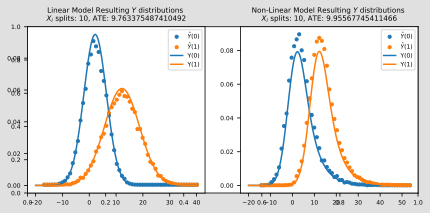

In [ ]:
plt.subplots(figsize=(7, 3))

plt.subplot(1, 2, 1)
lin_Y = getY(lin_slbn)
plotResults(lin_Y, lin_pdf_df,
            f"Linear Model Resulting $Y$ distributions \n" \
            f"$X_i$ splits: {covariate_num_split}, ATE: {getTau(lin_Y)}")

plt.subplot(1, 2, 2)

nl_Y = getY(nl_slbn)
plotResults(nl_Y, nl_pdf_df,
            f"Non-Linear Model Resulting $Y$ distributions \n" \
            f"$X_i$ splits: {covariate_num_split}, ATE: {getTau(nl_Y)}")

In [ ]:
lin_tau_hat_arr = []
nl_tau_hat_arr = []

num_obs_list = [5000, 10000, 20000, 40000]
num_shots = 10

for i in num_obs_list:
    lin_tau_hat_arr.append(list())
    nl_tau_hat_arr.append(list())
    for j in range(num_shots):

        lin_df = linear_simulation(i, 1.0)
        nl_df = non_linear_simulation(i, 1.0)

        discretizer = skbn.BNDiscretizer("uniform", 30)

        lin_template = discretizer.discretizedBN(lin_df)
        lin_struct_learner = gum.BNLearner(lin_df, lin_template)
        lin_slbn = lin_struct_learner.learnBN()

        nl_template = discretizer.discretizedBN(nl_df)
        nl_struct_learner = gum.BNLearner(nl_df, nl_template)
        nl_slbn = nl_struct_learner.learnBN()

        lin_Y_hat = getY(lin_slbn)
        lin_tau_hat = getTau(lin_Y_hat)
        lin_tau_hat_arr[-1].append(lin_tau_hat)

        nl_Y_hat = getY(nl_slbn)
        nl_tau_hat = getTau(nl_Y_hat)
        nl_tau_hat_arr[-1].append(nl_tau_hat)

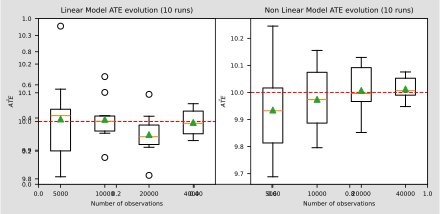

In [ ]:
plt.subplots(figsize=(7, 3))

plt.subplot(1, 2, 1)

plt.boxplot(lin_tau_hat_arr, tick_labels=num_obs_list, meanline=False,
            showmeans=True, showcaps=True)
plt.axhline(y=10, color='r', linestyle='--', linewidth=1)
plt.title(f"Linear Model ATE evolution ({num_shots} runs)")
plt.xlabel("Number of observations")
plt.ylabel(r"$\hat{ATE}$")

plt.subplot(1, 2, 2)

plt.boxplot(nl_tau_hat_arr, tick_labels=num_obs_list, meanline=False,
            showmeans=True, showcaps=True)
plt.axhline(y=10, color='r', linestyle='--', linewidth=1)
plt.title(f"Non Linear Model ATE evolution ({num_shots} runs)")
plt.xlabel("Number of observations")
plt.ylabel(r"$\hat{ATE}$")

plt.show()